# wps-pipeline-notebook

This is jupyter notebook for the example use of the wps services that are provided by the GFZ in the RIESGOS project.


In [51]:
%load_ext autoreload
%autoreload 2
import owslib.wps as wps
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import numpy as np
import lxml.etree as le
#from mpl_toolkits.basemap import Basemap
import gfzwpsformatconversions
#
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
WPS_URL = 'http://rz-vm140.gfz-potsdam.de/wps/WebProcessingService'

In [5]:
server = wps.WebProcessingService(WPS_URL)

So lets see what processes are supported:

In [6]:
server.processes

[<owslib.wps.Process org.n52.wps.server.algorithm.r.AnnotationValidation>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakemapTransformationProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.FlooddamageTiffDownloader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.NrmlCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakemapCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedFlooddamageTiffDownloader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.GeotiffBindingCacheReader>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.CachedSystemReliabilityProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.SystemReliabilityProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.FlooddamageProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.ShakygroundProcess>,
 <owslib.wps.Process org.n52.gfz.riesgos.algorithm.impl.QuakeledgerProcess>,
 <owslib.wps.Process org

Some of them are test processes, some others are included by default.
We will focus on the following:

| Process | Use case |
|---------|----------|
| Assetmaster | Extraction of the exposure model for a given location |
| Modelprop | Extraction of the vulnerability model with the fragility functions |
| Quakeledger | Earth quake catalog that we use to search for specific events |
| Shakyground | Computation of the pga for a given event |
| Deus | Update of the exposure model with damage states after using the intensities of a given event |

The processes are following a pipeline.

1. Assetmaster
2. Modelprop
3. Quakeledger
4. Shakyground
5. Deus

The order for assetmaster, modelprop and quakeledger can change is not strongly needed. They can be used in any order. However we need to use quakeledger before shakyground and we have to use all other processes before deus (as it needs the exposure model, the fragility functions and the intenstities computed in shakyground).

## Assetmaster
We will start working with the assetmaster dataset.

In [7]:
ID_ASSETMASTER = 'org.n52.gfz.riesgos.algorithm.impl.AssetmasterProcess'

In [8]:
execution_assetmaster = server.execute(
    identifier=ID_ASSETMASTER, 
    inputs=[
        ('lonmin', '-71.8'),
        ('lonmax', '-71.4'),
        ('latmin', '-33.2'),
        ('latmax', '-33.0'),
        ('schema', 'SARA_v1.0'),
        ('assettype', 'res'),
        ('querymode', 'intersects')
    ],
    output=[('selectedRowsGeoJson', True)]
)

wps.monitorExecution(execution_assetmaster)
print('Successful: {}'.format(execution_assetmaster.isSucceded()))

Successful: True


In [9]:
assetmaster_output_reference = execution_assetmaster.processOutputs[0].reference
assetmaster_output_pure = requests.get(assetmaster_output_reference).text
assetmaster_output = gpd.read_file(assetmaster_output_reference)

In [10]:
assetmaster_output.head()

,gid,name,expo,geometry
0,CHL.16.7.3_1,Quilpue,"{'Repl_cost_USD/bdg': {'1022': 288000, '1033':...",(POLYGON ((-71.44433593749994 -33.082408905029...
1,CHL.16.7.5_1,Valparaiso,"{'Repl_cost_USD/bdg': {'907': 35000, '918': 52...",(POLYGON ((-71.68458557128906 -33.102466583251...
2,CHL.16.7.7_1,Vina del Mar,"{'Repl_cost_USD/bdg': {'1091': 288000, '1090':...",(POLYGON ((-71.55708312988281 -33.014583587646...


In [61]:
pd.DataFrame(assetmaster_output.iloc[0].expo)

,Repl_cost_USD/bdg,Taxonomy,Buildings,name,Region,Population,id,Damage,Dwellings
1022,288000,"MCF/DUC/H:1,3",641.1,Quilpue,Quilpué,9107.2,AREA # 05106,D0,2564.2
1033,35000,W+WS/H:1,1159.9,Quilpue,Quilpué,4111.6,AREA # 05106,D0,1159.9
1021,94500,"MCF/DNO/H:1,3",3208.0,Quilpue,Quilpué,17094.5,AREA # 05106,D0,4812.0
1032,108000,"W+WLI/H:1,3",3901.9,Quilpue,Quilpué,20758.2,AREA # 05106,D0,5852.8
1020,35000,MCF/DNO/H:1,1362.8,Quilpue,Quilpué,4840.5,AREA # 05106,D0,1362.8
1031,72000,W+WLI/H:1,745.5,Quilpue,Quilpué,2644.7,AREA # 05106,D0,745.5
1030,35000,UNK,2519.0,Quilpue,Quilpué,8937.3,AREA # 05106,D0,2519.0
1019,43750,"ER+ETR/H:1,2",178.1,Quilpue,Quilpué,782.5,AREA # 05106,D0,222.6
1018,35000,ER+ETR/H:1,30.9,Quilpue,Quilpué,106.6,AREA # 05106,D0,30.9
1029,52500,"MUR/H:1,3",1959.0,Quilpue,Quilpué,10434.7,AREA # 05106,D0,2938.5


### TODO
Add a basemap for the cells.

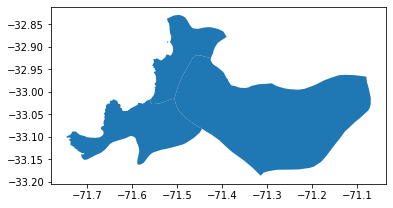

In [11]:
assetmaster_output.plot()

## Modelprop
Next is the modelprop process.

In [12]:
ID_MODELPROP = 'org.n52.gfz.riesgos.algorithm.impl.ModelpropProcess'

In [13]:
execution_modelprop = server.execute(
    identifier=ID_MODELPROP, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('assetcategory', 'buildings'),
        ('losscategory', 'structural'),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_modelprop)
print('Successful: {}'.format(execution_modelprop.isSucceded()))

Successful: True


In [14]:
modelprop_output_reference = execution_modelprop.processOutputs[0].reference
modelprop_output_pure = requests.get(modelprop_output_reference).text
modelprop_output = requests.get(modelprop_output_reference).json()

In [15]:
modelprop_output

{'data': [{'D1_stddev': 0.8,
   'D1_mean': 5.9,
   'D2_stddev': 0.8,
   'D4_mean': 8.2,
   'D4_stddev': 0.8,
   'D3_mean': 7.3,
   'D3_stddev': 0.8,
   'D5_stddev': 0.8,
   'taxonomy': 'URM1',
   'im_min': 1.0,
   'imu': 'g',
   'im_max': 12.0,
   'D2_mean': 6.7,
   'imt': 'pga',
   'D5_mean': 9.2,
   'id': 'unique_id'},
  {'D1_stddev': 0.9,
   'D1_mean': 6.2,
   'D2_stddev': 0.9,
   'D4_mean': 8.7,
   'D4_stddev': 0.9,
   'D3_mean': 7.8,
   'D3_stddev': 0.9,
   'D5_stddev': 0.9,
   'taxonomy': 'URM2',
   'im_min': 1.0,
   'imu': 'g',
   'im_max': 12.0,
   'D2_mean': 7.0,
   'imt': 'pga',
   'D5_mean': 9.8,
   'id': 'unique_id'},
  {'D1_stddev': 1.0,
   'D1_mean': 7.6,
   'D2_stddev': 1.0,
   'D4_mean': 10.5,
   'D4_stddev': 1.0,
   'D3_mean': 9.6,
   'D3_stddev': 1.0,
   'D5_stddev': 1.0,
   'taxonomy': 'CM',
   'im_min': 1.0,
   'imu': 'g',
   'im_max': 12.0,
   'D2_mean': 8.7,
   'imt': 'pga',
   'D5_mean': 11.5,
   'id': 'unique_id'},
  {'D1_stddev': 1.0,
   'D1_mean': 7.6,
   'D2_

In [16]:
urm1_functions = [x for x in modelprop_output['data'] if x['taxonomy'] == 'URM1'][0]

In [17]:
cdf_urm1_d4 = lognorm(scale=np.exp(urm1_functions['D4_mean']), s=urm1_functions['D4_stddev']).cdf

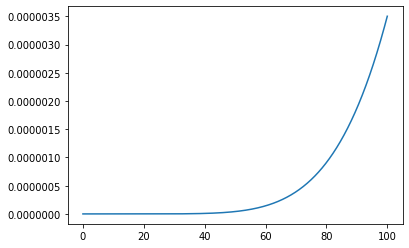

In [18]:
xs = np.linspace(0, 100, 1000)
ys = cdf_urm1_d4(xs)
plt.plot(xs, ys)

## Quakeledger
Now we are interested in the events in our region.

In [19]:
ID_QUAKELEDGER = 'org.n52.gfz.riesgos.algorithm.impl.QuakeledgerProcess'

In [20]:
execution_quakeledger = server.execute(
    identifier=ID_QUAKELEDGER, 
    inputs=[
        ('input-boundingbox', wps.BoundingBoxDataInput([-70, 288 - 360, -10, 292 - 360], 'EPSG:4326')),
        ('mmin', '6.6'),
        ('mmax', '9'),
        ('zmin', '5'),
        ('zmax', '140'),
        ('p', '140'),
        ('etype', 'expert'),
        ('tlon', '-71.5730623712764'),
        ('tlat', '-33.1299174879672'),
    ],
    output=[('selectedRows', True)]
)

wps.monitorExecution(execution_quakeledger)
print('Successful: {}'.format(execution_quakeledger.isSucceded()))

Successful: True


In [21]:
quakeledger_output_reference = execution_quakeledger.processOutputs[0].reference
quakeledger_output = le.fromstring(requests.get(quakeledger_output_reference).content)

In [22]:
quakeledger_output

<Element {http://quakeml.org/xmlns/bed/1.2}eventParameters at 0x13320afa0>

In [23]:
quakeledger_output_df = gfzwpsformatconversions.QuakeML.from_xml(quakeledger_output).to_geodataframe()

In [24]:
quakeledger_output_df.head()

,eventID,agency,Identifier,year,month,day,hour,minute,second,timeUncertainty,...,magnitudeUncertainty,rake,rakeUncertainty,dip,dipUncertainty,strike,strikeUncertainty,type,probability,geometry
0,quakeml:quakeledger/CHOA_122,GFZ,NaN,2018,1,1,0,0,0,NaN,...,NaN,90,NaN,18,NaN,9,NaN,expert,NaN,POINT (-71.2736 -28.6384)
1,quakeml:quakeledger/CHOA_123,GFZ,NaN,2018,1,1,0,0,0,NaN,...,NaN,90,NaN,18,NaN,9,NaN,expert,NaN,POINT (-71.3583 -29.082)
2,quakeml:quakeledger/CHOA_124,GFZ,NaN,2018,1,1,0,0,0,NaN,...,NaN,90,NaN,18,NaN,9,NaN,expert,NaN,POINT (-71.4439 -29.5256)
3,quakeml:quakeledger/CHOA_125,GFZ,NaN,2018,1,1,0,0,0,NaN,...,NaN,90,NaN,18,NaN,9,NaN,expert,NaN,POINT (-71.5303 -29.9692)
4,quakeml:quakeledger/CHOA_126,GFZ,NaN,2018,1,1,0,0,0,NaN,...,NaN,90,NaN,18,NaN,9,NaN,expert,NaN,POINT (-71.6176 -30.4128)


In [25]:
def get_bbox(geom_column):
    return [
        geom_column.x.min() - 1,
        geom_column.x.max() + 1,
        geom_column.y.min() - 1,
        geom_column.y.max() - 1
    ]
quakes_region = get_bbox(quakeledger_output_df.geometry)

In [26]:
quakes_region

[-72.9802, -70.2736, -32.7691, -29.6384]

In [27]:
def plot_quakedger(df):
    geom_column = df.geometry
    bbox = [
        geom_column.x.min() - 1,
        geom_column.x.max() + 1,
        geom_column.y.min() - 1,
        geom_column.y.max() - 1
    ]
    fig = plt.figure(figsize=(6, 12))
    mp = Basemap(projection='cyl', resolution='h', 
                 lat_0=bbox[2], lon_0=bbox[0],
                 llcrnrlon=bbox[0],
                 llcrnrlat=bbox[2],
                 urcrnrlon=bbox[1],
                 urcrnrlat=bbox[3]
    )
    mp.arcgisimage(service='World_Shaded_Relief', xpixels = 2000, verbose=False)
    mp.drawcoastlines()
    mp.drawcountries()
    mp.scatter(df.geometry.x, df.geometry.y,
           marker='o',color='m',s = (0.4*df.magnitude.values.astype(float))**4)
    plt.show()

In [28]:
plot_quakedger(quakeledger_output_df)

NameError: name 'Basemap' is not defined

<Figure size 432x864 with 0 Axes>

## Chose an event
Now we want to have chose one of those events and prepare it as input for our shakyground service.

In [29]:
chosen_event = quakeledger_output_df[0:1]

In [30]:
chosen_event

,eventID,agency,Identifier,year,month,day,hour,minute,second,timeUncertainty,...,magnitudeUncertainty,rake,rakeUncertainty,dip,dipUncertainty,strike,strikeUncertainty,type,probability,geometry
0,quakeml:quakeledger/CHOA_122,GFZ,NaN,2018,1,1,0,0,0,NaN,...,NaN,90,NaN,18,NaN,9,NaN,expert,NaN,POINT (-71.2736 -28.6384)


In [31]:
chosen_event_as_quakeml = gfzwpsformatconversions.QuakeMLDataframe.from_dataframe(chosen_event).to_xml_string()

In [32]:
chosen_event_as_quakeml

'<ns0:eventParameters xmlns:ns0="http://quakeml.org/xmlns/bed/1.2" publicID="quakeml:quakeledger/0">\n  <ns0:event publicID="quakeml:quakeledger/CHOA_122">\n    <ns0:preferredOriginID>quakeml:quakeledger/CHOA_122</ns0:preferredOriginID>\n    <ns0:preferredMagnitudeID>quakeml:quakeledger/CHOA_122</ns0:preferredMagnitudeID>\n    <ns0:type>earthquake</ns0:type>\n    <ns0:description>\n      <ns0:text>expert</ns0:text>\n    </ns0:description>\n    <ns0:origin publicID="quakeml:quakeledger/CHOA_122">\n      <ns0:time>\n        <ns0:value>2018-01-01T00:00:00.000000Z</ns0:value>\n        <ns0:uncertainty>NaN</ns0:uncertainty>\n      </ns0:time>\n      <ns0:latitude>\n        <ns0:value>-28.6384</ns0:value>\n        <ns0:uncertainty>NaN</ns0:uncertainty>\n      </ns0:latitude>\n      <ns0:longitude>\n        <ns0:value>-71.2736</ns0:value>\n        <ns0:uncertainty>NaN</ns0:uncertainty>\n      </ns0:longitude>\n      <ns0:depth>\n        <ns0:value>43.0</ns0:value>\n        <ns0:uncertainty>Na

# Shakyground
Now lets use the chosen event to get the data of the shakemap.

In [34]:
ID_SHAKYGROUND = 'org.n52.gfz.riesgos.algorithm.impl.ShakygroundProcess'


In [35]:
execution_shakyground = server.execute(
    identifier=ID_SHAKYGROUND, 
    inputs=[
        ('quakeMLFile', wps.ComplexDataInput(chosen_event_as_quakeml)),
    ],
    output=[('shakeMapFile', True)]
)

wps.monitorExecution(execution_shakyground)
print('Successful: {}'.format(execution_shakyground.isSucceded()))

Successful: True


In [37]:
shakyground_output_reference = execution_shakyground.processOutputs[0].reference
shakyground_output = le.fromstring(requests.get(shakyground_output_reference).content)

Now we want to visualize the shakemap.

In [38]:
shakyground_output_intensity_df = gfzwpsformatconversions.Shakemap.from_xml(shakyground_output).to_intensity_geodataframe()

In [39]:
shakyground_output_intensity_df.head()

,LON,LAT,value_PGA,value_STDPGA,unit_PGA,unit_STDPGA,geometry
0,-75.175000,-24.183333,0.071337,0.736259,g,g,POINT (-75.175 -24.1833333333)
1,-75.166667,-24.183333,0.071212,0.736259,g,g,POINT (-75.1666666667 -24.1833333333)
2,-75.158333,-24.183333,0.071087,0.736259,g,g,POINT (-75.15833333329999 -24.1833333333)
3,-75.150000,-24.183333,0.070963,0.736259,g,g,POINT (-75.15000000000001 -24.1833333333)
4,-75.141667,-24.183333,0.070839,0.736259,g,g,POINT (-75.1416666667 -24.1833333333)


In [40]:
raster = gfzwpsformatconversions.Shakemap.dataframe2raster(shakyground_output_intensity_df, 'LON', 'LAT', 'value_PGA')

In [41]:
event_dataframe = gfzwpsformatconversions.Shakemap.from_xml(shakyground_output).to_event_geodataframe_or_none()

In [79]:
def plot_shakemap(raster, events, additional_spacing=1):
    cmap = plt.get_cmap('YlOrBr')
    z = raster.raster.data
    y_count, x_count = z.shape
    x_s = np.linspace(raster.xmin, raster.xmax, x_count)
    # the image coordinates for ys go down
    y_s = np.linspace(raster.ymax, raster.ymin, y_count)
    
    # dont plot some values
    # to make the image not that full
    zz = np.ma.masked_array(z, z < 0.1)
    
    bbox = raster.bounds
    fig = plt.figure(figsize=(6, 12))
    mp = Basemap(projection='cyl', resolution='h', 
                 #lat_0=bbox[2], 
                 #lon_0=bbox[0],
                 llcrnrlon=bbox[0] - additional_spacing,
                 llcrnrlat=bbox[1] - additional_spacing,
                 urcrnrlon=bbox[2] + additional_spacing,
                 urcrnrlat=bbox[3] + additional_spacing
    )
    mp.arcgisimage(service='World_Shaded_Relief', xpixels = 2000, verbose=False)
    mp.drawcoastlines()
    mp.drawcountries()
    cs = mp.pcolormesh(x_s, y_s, zz, zorder=98, alpha=0.3, cmap=cmap)
    mp.colorbar(cs, extend='min')
    
    mp.scatter(events.geometry.x, events.geometry.y,
               zorder=99,
               marker='*',color='red',s = 30**2)
    plt.show()

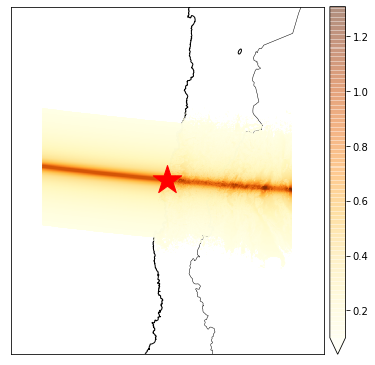

In [80]:
plot_shakemap(raster, event_dataframe)

# Deus
At the moment the last service to use here.

In [42]:
ID_DEUS = 'org.n52.gfz.riesgos.algorithm.impl.DeusProcess'

In [44]:
execution_deus = server.execute(
    identifier=ID_DEUS, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('exposure', wps.ComplexDataInput(assetmaster_output_pure)),
        ('fragility', wps.ComplexDataInput(modelprop_output_pure)),
        ('intensity', wps.ComplexDataInput(le.tostring(shakyground_output)))
    ],
    output=[
        ('updated_exposure', True),
        ('transition', True),
        ('damage', True),
    ]
)

wps.monitorExecution(execution_deus)
print('Successful: {}'.format(execution_deus.isSucceded()))

 owslib.wps.WPSException : {'code': 'NoApplicableCode', 'locator': None, 'text': 'org.n52.wps.server.ExceptionReport: There is an error on stderr'}
Successful: False


# Failing is ok
If this fails, we just see that the assetmaster and modelprop outputs are not conform to each other.
As this is the current return value of the services it is ok, that the deus service fails.
We will now chose some data that we can use without generating an error.

In [45]:
def read_string_from_file(file):
    with open(file, 'rt') as input_file:
        return input_file.read()

execution_deus = server.execute(
    identifier=ID_DEUS, 
    inputs=[
        ('schema', 'SARA_v1.0'),
        ('exposure', wps.ComplexDataInput(read_string_from_file('testinputs/exposure_sara.json'))),
        ('fragility', wps.ComplexDataInput(read_string_from_file('testinputs/fragility_sara.json'))),
        
        #('intensity', wps.ComplexDataInput(le.tostring(shakyground_output, encoding='unicode')))
        # this here doesn't work either at the moment
        # we have have a look for what happens here
        
        ('intensity', wps.ComplexDataInput(read_string_from_file('testinputs/shakemap.xml')))
        
    ],
    output=[
        ('updated_exposure', True),
        ('transition', True),
        ('damage', True),
    ]
)

wps.monitorExecution(execution_deus)
print('Successful: {}'.format(execution_deus.isSucceded()))

Successful: True


In [46]:
updated_exposure_model_reference = execution_deus.processOutputs[0].reference
updated_exposure_model_df = gpd.read_file(updated_exposure_model_reference, )

In [64]:
updated_exposure_model_transitions =  requests.get(execution_deus.processOutputs[1].reference).json()

In [68]:
updated_exposure_model_transition

{'features': [{'geometry': {'coordinates': [[[[-71.63468933105463,
        -33.3686408996582],
       [-71.62964630126953, -33.35897064208979],
       [-71.62679290771484, -33.35404968261719],
       [-71.62269592285156, -33.348850250244084],
       [-71.61915588378906, -33.34518814086914],
       [-71.61559295654291, -33.34225082397461],
       [-71.60900115966797, -33.33580017089838],
       [-71.60417175292963, -33.331890106201115],
       [-71.59686279296875, -33.325340270996094],
       [-71.59245300292969, -33.31805038452143],
       [-71.58856964111328, -33.31087112426758],
       [-71.5845108032226, -33.3015403747558],
       [-71.58154296874994, -33.29243850708008],
       [-71.57894134521484, -33.28202056884754],
       [-71.57686614990229, -33.272430419921875],
       [-71.57691955566406, -33.26681900024414],
       [-71.57752990722656, -33.261348724365234],
       [-71.58004760742176, -33.25701904296869],
       [-71.58436584472656, -33.253150939941406],
       [-71.5881195

In [47]:
updated_exposure_model_df

,id,MR_H1_3_DUC_D0,gc_id,MUR_ADO_H1_2_D2,MUR_STRUB_H1_2_D1,MUR_ADO_H1_2_D1,MUR_STRUB_H1_2_D2,MUR_ADO_H1_2_D4,MUR_ADO_H1_2_D3,MUR_STRUB_H1_2_D0,...,MUR_H1_D3,MUR_H1_D4,ER_ETR_H1_2_D0,ER_ETR_H1_2_D2,ER_ETR_H1_2_D1,MCF_H1_3_DUC_D0,CR_LFLS_H1_3_DUC_D0,CR_LFLS_H1_3_DUC_D1,CR_LFLS_H1_3_DUC_D2,geometry
0,0,0.0,CHL.16.7.1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,(POLYGON ((-71.63468933105463 -33.368640899658...
1,1,862.1,CHL.16.7.3_1,0.0,0.0,0.0,0.0,0.0,0.0,35.2,...,0.0,0.0,301.9,0.0,0.0,91.5,30.9,0.0,0.0,(POLYGON ((-71.44433593749994 -33.082408905029...
2,2,931.1,CHL.16.7.5_1,0.0,0.0,0.0,0.0,0.0,0.0,138.4,...,0.0,0.0,415.8,0.0,0.0,203.4,267.5,0.0,0.0,(POLYGON ((-71.68458557128906 -33.102466583251...
3,3,1343.2,CHL.16.7.7_1,0.0,0.0,0.0,0.0,0.0,0.0,364.0,...,0.0,0.0,508.4,0.0,0.0,184.8,58.1,0.0,0.0,(POLYGON ((-71.55708312988281 -33.014583587646...


Here all of the buildings are still in the damage state 0.

# Next steps
The next steps are more support for the assetmaster, modelprop and deus as they need to work togehter.
Also we may can provide a wps client library on top of the code here to access the services mentioned here and as a skeleton on how to write clients for other services as well.